In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import sys
import os

# Add the root of the project to sys.path
# Assuming notebooks and src are in the same parent directory
project_root = os.path.dirname(os.getcwd())  # Get the parent directory of the current working directory
sys.path.append(project_root)

from src.visualization import NumericVisualizer, CategoricalVisualizer

In [2]:
df.info(), df.describe()

NameError: name 'df' is not defined

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", 
                 header=None, names=['StaAcc', 'DuMon', 'CredHis', 'Purpose', 'CredAmt', 'SavAcc', \
                                     'PreEmpl', 'InsRt', 'PerSta', 'OthDebtor', 'PreRe', 'Property', \
                                     'Age', 'IntPla', 'Housing', 'ExstCredit', 'Job', 'NoMain', 'Phone', 'ForWorker', "Response"], 
                 index_col=None, sep=" ")
df.head()


,StaAcc,DuMon,CredHis,Purpose,CredAmt,SavAcc,PreEmpl,InsRt,PerSta,OthDebtor,...,Property,Age,IntPla,Housing,ExstCredit,Job,NoMain,Phone,ForWorker,Response
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns
cat_cols = df.select_dtypes(include='O').columns
cat_cols

Index(['StaAcc', 'CredHis', 'Purpose', 'SavAcc', 'PreEmpl', 'PerSta',
       'OthDebtor', 'Property', 'IntPla', 'Housing', 'Job', 'Phone',
       'ForWorker'],
      dtype='object')

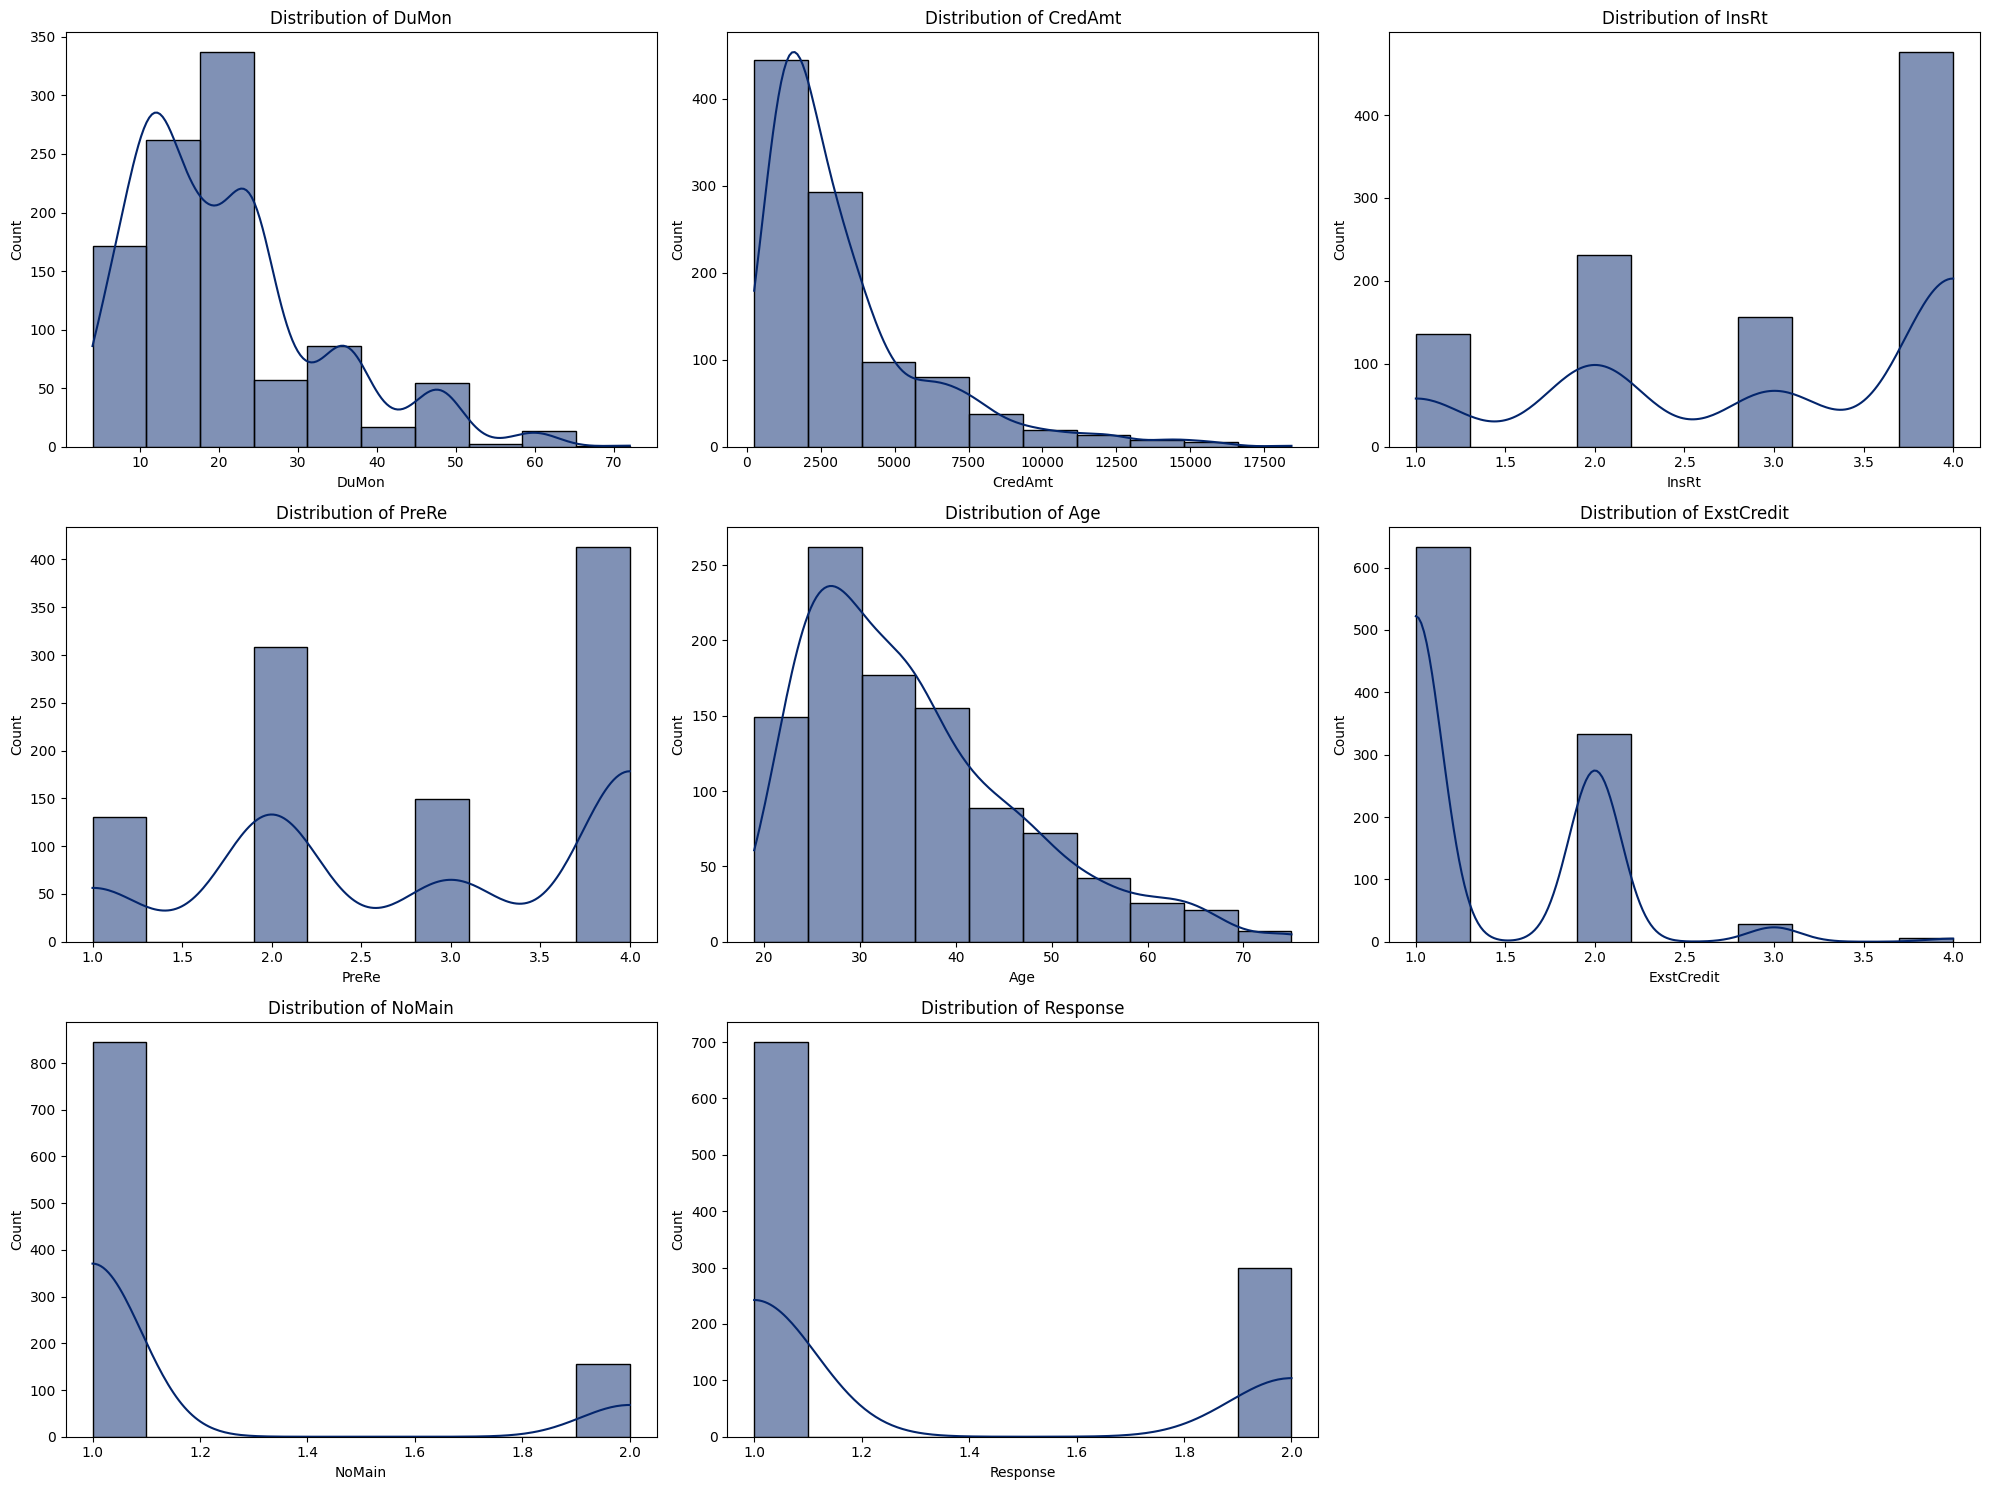

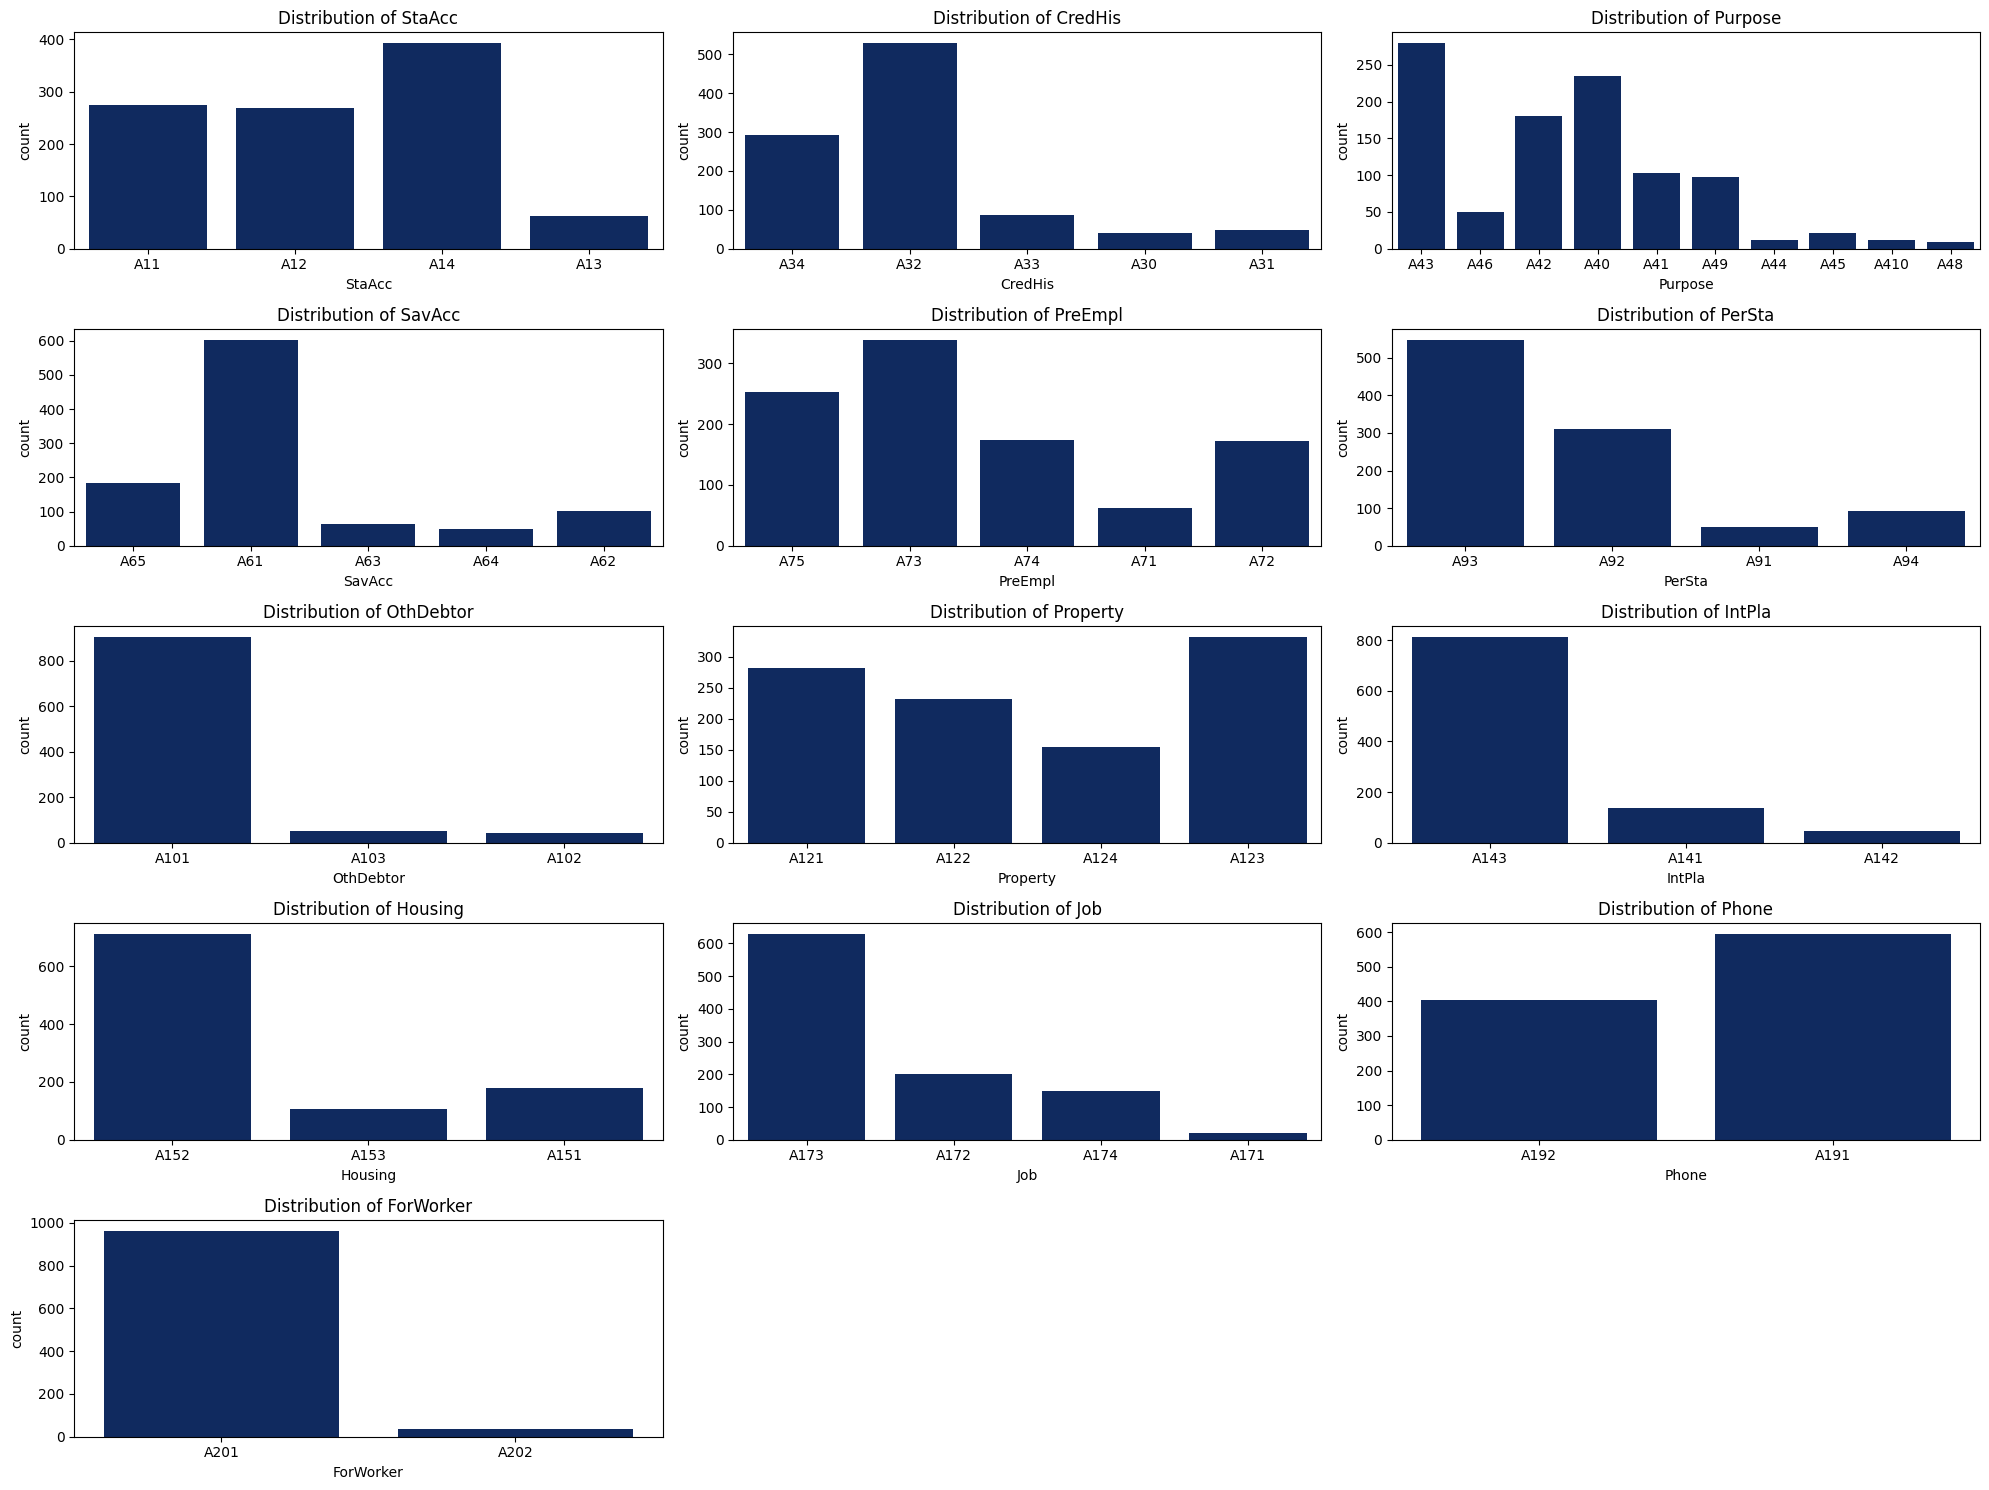

In [5]:
# Create instances of the visualizers
numeric_visualizer = NumericVisualizer(df)
categorical_visualizer = CategoricalVisualizer(df)


numeric_visualizer.plot(
    numeric_cols,
    figsize=(20,15)
)
categorical_visualizer.plot(
    cat_cols,
    figsize=(20,15)
)


In [6]:
df_train, df_test = train_test_split(
    df,
    test_size = 0.2,
    stratify = df['Response']
)

X_train = df_train.copy()
y_train = X_train.pop('Response')

X_test = df_test.copy()
y_test = X_test.pop('Response')

In [7]:
cat_names = list(X_train.select_dtypes('object').columns)
num_names = list(X_train.select_dtypes(['float', 'int']).columns)

In [8]:
cat_pl = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder()) 
])

num_pl = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7)), 
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pl, num_names),
    ('cat', cat_pl, cat_names)
])

In [9]:
completed_pl = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

completed_pl.fit(X_train, y_train)
y_train_pred = completed_pl.predict(X_train)

print(f'Accuracy on train: {accuracy_score(list(y_train),list(y_train_pred))}')

y_test_pred = completed_pl.predict(X_test)
print(f'Accuracy on test: {accuracy_score(list(y_test),list(y_test_pred))}')

Accuracy on train: 1.0
Accuracy on test: 0.775


In [10]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import numpy as np

def fbeta(y_true, y_pred):
    return fbeta_score(
        y_true,
        y_pred,
        beta=np.sqrt(5)
    )

In [11]:
cv = RepeatedStratifiedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=1
)
metric = make_scorer(fbeta)
scores = cross_val_score(
    completed_pl,
    X_train,
    y_train,
    scoring=metric,
    cv=cv,
    n_jobs=-1
)
print('Mean Fbeta{:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))

Mean Fbeta0.897 0.030


In [12]:
models = [GaussianNB(), LogisticRegression(max_iter=1000, tol=1e-4, solver='lbfgs'), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier()]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = [
    cross_val_score(
        Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ]
        ),
        X_train,
        y_train,
        scoring=metric,
        cv=cv,
        n_jobs=-1
    )
    for model in models
]

/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_percep

Text(0.5, 1.0, 'Scores Metrics')

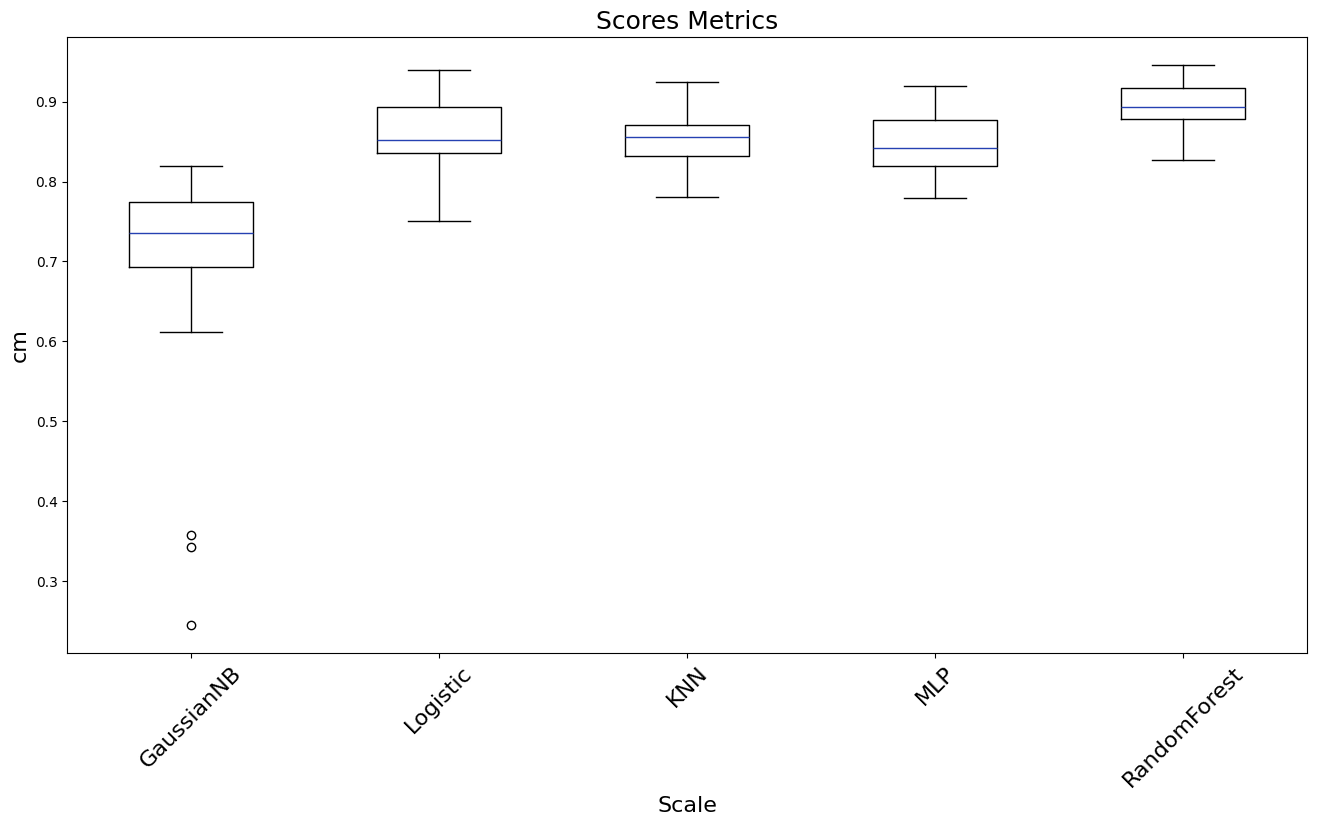

In [13]:
model_names = ['GaussianNB', 'Logistic', 'KNN', 'MLP', 'RandomForest']

plt.figure(figsize=(16, 8))
plt.boxplot(scores)
plt.xlabel('Scale', fontsize=16)
plt.ylabel('cm', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

In [14]:
from sklearn.base import BaseEstimator
class ClassifierSwitcher(BaseEstimator):
  def __init__(
      self, 
      estimator = RandomForestClassifier(),
  ):
      """
      A Custom BaseEstimator that can switch between classifiers.
      :param estimator: sklearn object - The classifier
      """ 
      
      self.estimator = estimator


  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self


  def predict(self, X, y=None):
      return self.estimator.predict(X)


  def predict_proba(self, X):
      return self.estimator.predict_proba(X)


  def score(self, X, y):
      return self.estimator.score(X, y)

In [15]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', ClassifierSwitcher())
])

In [20]:
parameters = [
    {
        'clf__estimator': [LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)],
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4]
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth': [5, 10],
        'clf__estimator__criterion': ('gini', 'entropy')
    },
]

In [21]:
metric= make_scorer(fbeta)

gscv = GridSearchCV(
    pipeline,
    parameters,
    cv=5,
    n_jobs=12,
    scoring=metric,
    return_train_score=True,
    error_score=0,
    verbose=3
)

gscv.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 2/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga'), clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001;, score=(train=0.887, test=0.840) total time=   0.0s
[CV 1/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga'), clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001;, score=(train=0.894, test=0.856) total time=   0.0s
[CV 3/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga'), clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001;, score=(train=0.892, test=0.904) total time=   0.0s
[CV 4/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga'), clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001;, score=(train=0.893, test=0.857) total time=   

/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/aaronnguyen/Documents/PersonalProjects/azure-mlops/venv-mlops/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/aaron

[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.956, test=0.915) total time=   0.1s
[CV 5/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga'), clf__estimator__max_iter=80, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001;, score=(train=0.880, test=0.851) total time=   0.1s
[CV 2/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga'), clf__estimator__max_iter=80, clf__estimator__penalty=l1, clf__estimator__tol=0.0001;, score=(train=0.891, test=0.824) total time=   0.1s
[CV 4/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga'), clf__estimator__max_iter=80, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001;, score=(train=0.897, test=0.857) total time=   0.1s
[CV 3/5] END clf__estimator=LogisticRegression(l1_ratio=0.5, penalty='elasti

GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=7)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['DuMon',
                                                                          'CredAmt',
                                                                          'InsRt',
                                                                          'PreRe',
                                                                          'Age',
                                                                          'ExstCredit',
                                                                          'NoMain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(...
                          'clf__estimator__max_iter': [50, 80],
                          'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
                          'clf__estimator__tol': [0.0001]},
                         {'clf__estimator': [RandomForestClassifier()],
                          'clf__estimator__criterion': ('gini', 'entropy'),
                          'clf__estimator__max_depth': [5, 10],
                          'clf__estimator__n_estimators': [50, 100]}],
             return_train_score=True,
             scoring=make_scorer(fbeta, response_method='predict'), verbose=3)

In [22]:
gscv.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DuMon', 'CredAmt', 'InsRt',
                                                   'PreRe', 'Age', 'ExstCredit',
                                                   'NoMain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['StaAcc', 'CredHis',
                                                   'Purpose', 'SavAcc',
                                                   'PreEmpl', 'PerSta',
                                                   'OthDebtor', 'Property',
                                                   'IntPla', 'Housing', 'Job',
                                                   'Phone', 'ForWorker'])])),
                ('clf',
                 ClassifierSwitcher(estimator=RandomForestClassifier(max_depth=5)))])

In [23]:
gscv.best_params_

{'clf__estimator': RandomForestClassifier(),
 'clf__estimator__criterion': 'gini',
 'clf__estimator__max_depth': 5,
 'clf__estimator__n_estimators': 100}

In [24]:
gscv.best_score_

0.9311056028298621